Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 5.2) 구매 기록 기반 상품 추천하기

### 바로가기

- [<Step1. 탐색적 분석> : UK Retail 데이터 분석하기](#<Step1.-탐색적-분석>-:-UK-Retail-데이터-분석하기)
    - [UK Retail 데이터셋의 기본 정보]
    - [탐색적 데이터 분석]
- [<Step2. 예측 분석> : SVD를 활용한 상품 구매 예측](#<Step2.-예측-분석>-:-SVD를-활용한-상품-구매-예측)
    - [피처 엔지니어링]
    - [SVD 모델 학습하기]
- [<Step3. 예측 평가하기> : 상품 추천 시뮬레이션](#<Step3.-예측-평가하기>-:-상품-추천-시뮬레이션)
    - [상품 추천 시뮬레이션]
    - [상품 추천 평가하기]

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# <Step1. 탐색적 분석> : UK Retail 데이터 분석하기

### [UK Retail 데이터셋의 기본 정보]

##### 데이터 피처 설명
- InvoiceNo : 거래 고유 번호
- StockCode : 상품 고유 번호
- Description : 상품명
- Quantity : 거래 수량
- InvoiceDate : 거래 일시
- UnitPrice : 상품 단가
- CustomerID : 구매자 고유 번호
- Country : 구매 국가

-----

##### 데이터 살펴보기

In [2]:
# 영국 선물샵 온라인 도매 거래 데이터
df = pd.read_csv("../data/online_retail.csv", dtype={'CustomerID': str,'InvoiceID': str}, encoding="ISO-8859-1")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%m/%d/%Y %H:%M")

In [3]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


-----

##### 결측 데이터 제거

In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df = df.dropna()
print(df.shape)

(406829, 8)


-----

##### 탐색 데이터의 조건 필터링

In [6]:
# 상품수량이 음수인 경우를 제거합니다.
print(df[df['Quantity']<=0].shape[0])
df = df[df['Quantity']>0]

8905


In [7]:
# 상품 가격이 0 이하인 경우를 제거합니다.
print(df[df['UnitPrice']<=0].shape[0])
df = df[df['UnitPrice']>0]

40


In [8]:
# 상품 코드가 일반적이지 않은 경우를 탐색합니다.
df['ContainDigit'] = df['StockCode'].apply(lambda x: any(c.isdigit() for c in x))
print(df[df['ContainDigit'] == False].shape[0])
df[df['ContainDigit'] == False].head()

1414


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ContainDigit
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583,France,False
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791,Netherlands,False
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662,Germany,False
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274,United Kingdom,False
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274,United Kingdom,False


In [9]:
# 상품 코드가 일반적이지 않은 경우를 제거합니다.
df = df[df['ContainDigit'] == True]

-----

### [탐색적 데이터 분석]

##### 일자별 거래 데이터 분석

In [10]:
# 거래 데이터에서 가장 오래된 데이터와 가장 최신의 데이터를 탐색합니다.
df['date'] = df['InvoiceDate'].dt.date
print(df['date'].min())
print(df['date'].max())

2010-12-01
2011-12-09


<AxesSubplot:xlabel='date'>

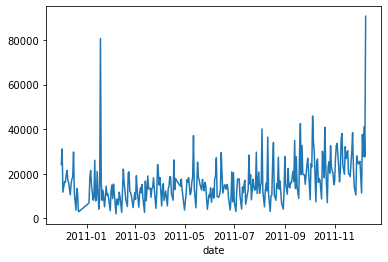

In [11]:
# 일자별 총 거래 수량을 탐색합니다.
date_quantity_series = df.groupby('date')['Quantity'].sum()
date_quantity_series.plot()

<AxesSubplot:xlabel='date'>

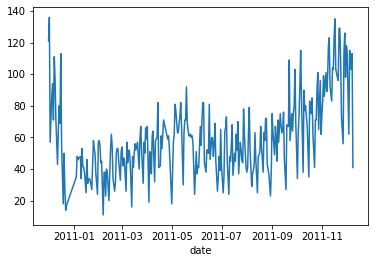

In [12]:
# 일자별 총 거래 횟수를 탐색합니다.
date_transaction_series = df.groupby('date')['InvoiceNo'].nunique()
date_transaction_series.plot()

<AxesSubplot:xlabel='date'>

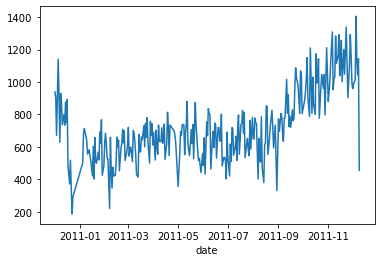

In [13]:
# 일자별 거래된 상품의 unique한 갯수, 즉 상품 거래 다양성을 탐색합니다.
date_unique_item_series = df.groupby('date')['StockCode'].nunique()
date_unique_item_series.plot()

-----

##### 유저별 구매 패턴 분석

In [14]:
# 총 유저의 수를 계산하여 출력합니다.
print(len(df['CustomerID'].unique()))

4334


In [15]:
# 유저별 거래 횟수를 탐색합니다.
customer_unique_transaction_series = df.groupby('CustomerID')['InvoiceNo'].nunique()
customer_unique_transaction_series.describe()

count    4334.000000
mean        4.246654
std         7.642535
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       206.000000
Name: InvoiceNo, dtype: float64

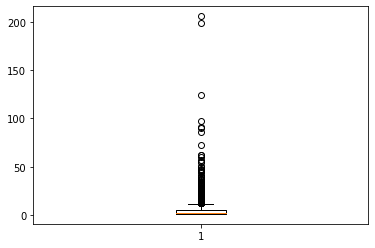

In [16]:
# 상자 그림 시각화로 살펴봅니다.
plt.boxplot(customer_unique_transaction_series.values)
plt.show()

In [17]:
# 유저별 아이템 구매 종류 개수를 탐색합니다.
customer_unique_item_series = df.groupby('CustomerID')['StockCode'].nunique()
customer_unique_item_series.describe()

count    4334.000000
mean       61.432856
std        85.312937
min         1.000000
25%        16.000000
50%        35.000000
75%        77.000000
max      1786.000000
Name: StockCode, dtype: float64

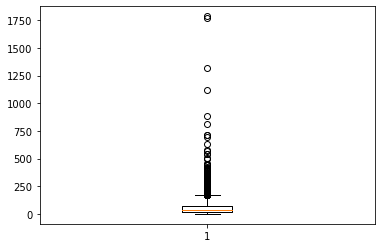

In [18]:
# 상자 그림 시각화로 살펴봅니다.
plt.boxplot(customer_unique_item_series.values)
plt.show()

-----

### `[미니 퀴즈 - 5.2]`
- `이번에는 유저가 아닌 상품을 기준으로 EDA를 실시해 보세요.` 
    - 아래의 내용들을 탐색적으로 분석해보도록 합시다.
        - 총 상품 갯수
        - 가장 거래가 많은 상품 top 10 탐색
        - 상품별 판매수량 분포 탐색
        - 거래별 가격 탐색

In [19]:
# 총 상품 갯수를 탐색합니다.
print(len(df['StockCode'].unique()))

3660


-----

In [20]:
# 가장 거래가 많은 상품 top 10 탐색
df.groupby('StockCode')['InvoiceNo'].nunique().sort_values(ascending=False)[:10]

StockCode
85123A    1978
22423     1703
85099B    1600
47566     1379
84879     1375
20725     1289
22720     1146
23203     1080
20727     1052
22383     1043
Name: InvoiceNo, dtype: int64

-----

count     3660.000000
mean      1409.149727
std       3513.654056
min          1.000000
25%         65.000000
50%        395.000000
75%       1417.500000
max      80995.000000
Name: Quantity, dtype: float64


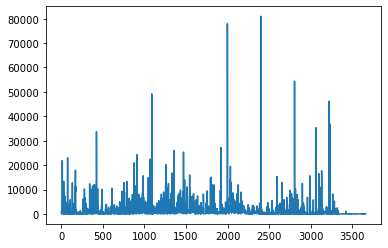

In [21]:
# 상품별 판매수량 분포를 탐색합니다.
print(df.groupby('StockCode')['Quantity'].sum().describe())
plt.plot(df.groupby('StockCode')['Quantity'].sum().values)
plt.show()

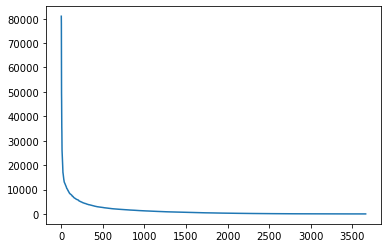

In [22]:
# 분포를 정렬하여 출력합니다.
plt.plot(df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).values)
plt.show()

-----

In [23]:
# 거래별로 발생한 가격에 대해 탐색합니다.
df['amount'] = df['Quantity'] * df['UnitPrice']
df.groupby('InvoiceNo')['amount'].sum().describe()

count     18405.000000
mean        476.378845
std        1678.749892
min           0.380000
25%         157.900000
50%         302.360000
75%         465.700000
max      168469.600000
Name: amount, dtype: float64

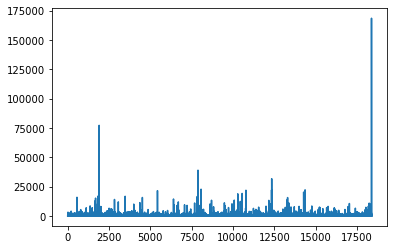

In [24]:
# 거래별로 발생한 가격 분포를 탐색합니다.
plt.plot(df.groupby('InvoiceNo')['amount'].sum().values)
plt.show()

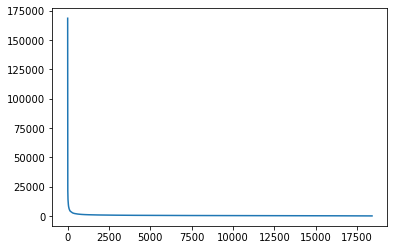

In [25]:
# 분포를 정렬하여 출력합니다.
plt.plot(df.groupby('InvoiceNo')['amount'].sum().sort_values(ascending=False).values)
plt.show()

-----

##### 시계열 기준으로 데이터 분리

In [26]:
import datetime

# 2011년 11월을 기준으로 하여, 기준 이전과 이후로 데이터를 분리합니다.
df_year_round = df[df['date'] < datetime.date(2011, 11, 1)]
df_year_end = df[df['date'] >= datetime.date(2011, 11, 1)]
print(df_year_round.shape)
print(df_year_end.shape)

(314902, 11)
(81568, 11)


-----

##### 분리된 데이터에서 구매 패턴 탐색 : 재구매, 신규구매 등의 여부

In [27]:
# 11월 이전 데이터에서 구매했던 상품의 set을 추출합니다.
customer_item_round_set = df_year_round.groupby('CustomerID')['StockCode'].apply(set)
print(customer_item_round_set)

CustomerID
12346                                              {23166}
12347    {84991, 23420, 21976, 22561, 21975, 23177, 224...
12348    {84991, 22952, 21725, 23076, 21981, 84988, 219...
12350    {21915, 22412, 84086C, 21866, 20615, 21908, 21...
12352    {37448, 21700, 22646, 22120, 22784, 22780, 217...
                               ...                        
18280    {22358, 22727, 22499, 82484, 22467, 22084, 226...
18281    {22716, 22467, 22037, 23007, 23209, 22028, 23008}
18282    {23187, 21108, 21109, 21270, 22089, 22424, 23295}
18283    {20886, 20712, 22757, 84991, 23354, 23353, 231...
18287    {22757, 21556, 22144, 47421, 85039A, 21817, 23...
Name: StockCode, Length: 3970, dtype: object


In [28]:
# 11월 이전에 구매했는지 혹은 이후에 구매했는지를 유저별로 기록하기 위한 사전을 정의합니다.
customer_item_dict = {}

# 11월 이전에 구매한 상품은 'old'라고 표기합니다.
for customer_id, stocks in customer_item_round_set.items():
    customer_item_dict[customer_id] = {}
    for stock_code in stocks:
        customer_item_dict[customer_id][stock_code] = 'old'

print(str(customer_item_dict)[:100] + "...")

{'12346': {'23166': 'old'}, '12347': {'84991': 'old', '23420': 'old', '21976': 'old', '22561': 'old'...


In [29]:
# 11월 이후 데이터에서 구매하는 상품의 set을 추출합니다.
customer_item_end_set = df_year_end.groupby('CustomerID')['StockCode'].apply(set)
print(customer_item_end_set)

CustomerID
12347    {23506, 23508, 23497, 23084, 21731, 84625A, 21...
12349    {21086, 23240, 22556, 37448, 85014B, 21787, 22...
12352    {23088, 22624, 23089, 22982, 22178, 21669, 226...
12356                                       {21843, 22423}
12357    {21116, 22718, 22023, 23197, 35599B, 21485, 72...
                               ...                        
18272    {23240, 22961, 22075, 20914, 23495, 23236, 234...
18273                                             {79302M}
18274    {21231, 23243, 23245, 21974, 84988, 21108, 224...
18282                  {22699, 23174, 22423, 22818, 23175}
18283    {20712, 84991, 23199, 22574, 21976, 23208, 233...
Name: StockCode, Length: 1904, dtype: object


In [30]:
# 11월 이전에만 구매한 상품은 'old', 이후에만 구매한 상품은 'new', 모두 구매한 상품은 'both'라고 표기합니다.

for customer_id, stocks in customer_item_end_set.items():
    # 11월 이전 구매기록이 있는 유저인지를 체크합니다.
    if customer_id in customer_item_dict:
        for stock_code in stocks:
            # 구매한 적 있는 상품인지를 체크한 뒤, 상태를 표기합니다.
            if stock_code in customer_item_dict[customer_id]:
                customer_item_dict[customer_id][stock_code] = 'both'
            else:
                customer_item_dict[customer_id][stock_code] = 'new'
    
    # 11월 이전 구매기록이 없는 유저라면 모두 'new'로 표기합니다.
    else:
        customer_item_dict[customer_id] = {}
        for stock_code in stocks:
            customer_item_dict[customer_id][stock_code] = 'new'

print(str(customer_item_dict)[:100] + "...")

{'12346': {'23166': 'old'}, '12347': {'84991': 'old', '23420': 'old', '21976': 'old', '22561': 'old'...


In [31]:
# 'old', 'new', 'both'를 유저별로 탐색하여 데이터 프레임을 생성합니다.
columns = ['CustomerID', 'old', 'new', 'both']
df_order_info = pd.DataFrame(columns=columns)

# 데이터 프레임을 생성하는 과정입니다.
for customer_id in customer_item_dict:
    old = 0
    new = 0
    both = 0
    
    # 딕셔너리의 상품 상태(old, new, both)를 체크하여 데이터 프레임에 append 할 수 있는 형태로 처리합니다.
    for stock_code in customer_item_dict[customer_id]:
        status = customer_item_dict[customer_id][stock_code]
        if status == 'old':
            old += 1
        elif status == 'new':
            new += 1
        else:
            both += 1
    
    # df_order_info에 데이터를 append합니다.
    row = [customer_id, old, new, both]
    series = pd.Series(row, index=columns)
    df_order_info = df_order_info.append(series, ignore_index=True)

df_order_info.head()

,CustomerID,old,new,both
0,12346,1,0,0
1,12347,92,3,8
2,12348,21,0,0
3,12350,16,0,0
4,12352,43,12,2


In [32]:
# 데이터 프레임에서 전체 유저 수를 출력합니다.
print(df_order_info.shape[0])

# 데이터 프레임에서 old가 1 이상이면서, new가 1 이상인 유저 수를 출력합니다. 
# 11월 이후에 기존에 구매한적 없는 새로운 상품을 구매한 유저를 의미합니다.
print(df_order_info[(df_order_info['old'] > 0) & (df_order_info['new'] > 0)].shape[0])

# 데이터 프레임에서 both가 1 이상인 유저 수를 출력합니다. 
# 재구매한 상품이 있는 유저 수를 의미합니다.
print(df_order_info[df_order_info['both'] > 0].shape[0])

4334
1446
1426


In [33]:
# new 피처의 value_counts를 출력하여, 새로운 상품을 얼마나 구매하는지 탐색합니다.
df_order_info['new'].value_counts()

0      2521
1        81
3        73
2        72
8        65
       ... 
108       1
113       1
115       1
116       1
391       1
Name: new, Length: 133, dtype: int64

In [34]:
# 만약 새로운 상품을 구매한다면, 얼마나 많은 종류의 새로운 상품을 구매하는지 탐색합니다.
print(df_order_info['new'].value_counts()[1:].describe())

count    132.000000
mean      13.734848
std       19.130672
min        1.000000
25%        1.000000
50%        5.000000
75%       16.000000
max       81.000000
Name: new, dtype: float64


-----

# <Step2. 예측 분석> : SVD를 활용한 상품 구매 예측

### [피처 엔지니어링]

In [35]:
# 추천 대상 데이터에 포함되는 유저와 상품의 갯수를 출력합니다.
print(len(df_year_round['CustomerID'].unique()))
print(len(df_year_round['StockCode'].unique()))

3970
3608


-----

##### SVD 모델에 사용할 데이터 : User-Item간의 Rating 데이터 생성 (U-I-R Matrix)

In [36]:
# Rating 데이터를 생성하기 위한 탐색 : 유저-상품간 구매 횟수를 탐색합니다.
uir_df = df_year_round.groupby(['CustomerID', 'StockCode'])['InvoiceNo'].nunique().reset_index()
uir_df.head()

,CustomerID,StockCode,InvoiceNo
0,12346,23166,1
1,12347,16008,1
2,12347,17021,1
3,12347,20665,1
4,12347,20719,3


<AxesSubplot:>

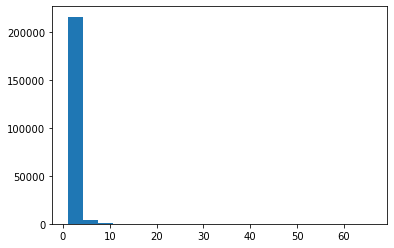

In [37]:
# Rating(InvoiceNo) 피처의 분포를 탐색합니다.
uir_df['InvoiceNo'].hist(bins=20, grid=False)

<AxesSubplot:>

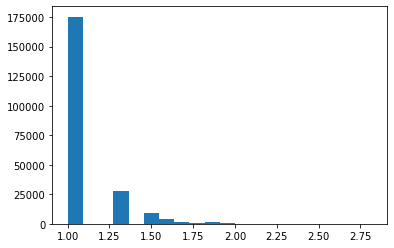

In [38]:
# Rating(InvoiceNo) 피처를 log normalization 해준 뒤, 다시 분포를 탐색합니다.
uir_df['InvoiceNo'].apply(lambda x: np.log10(x)+1).hist(bins=20, grid=False)

<AxesSubplot:>

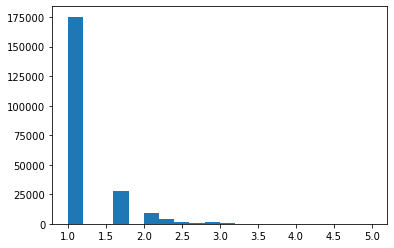

In [39]:
# 1~5 사이의 점수로 변환합니다.
uir_df['Rating'] = uir_df['InvoiceNo'].apply(lambda x: np.log10(x)+1)
uir_df['Rating'] = ((uir_df['Rating'] - uir_df['Rating'].min()) / 
                    (uir_df['Rating'].max() - uir_df['Rating'].min()) * 4) + 1
uir_df['Rating'].hist(bins=20, grid=False)

-----

### [SVD 모델 학습하기]

In [40]:
# SVD 모델 학습을 위한 데이터셋을 생성합니다.
uir_df = uir_df[['CustomerID', 'StockCode', 'Rating']]
uir_df.head()

,CustomerID,StockCode,Rating
0,12346,23166,1.000000
1,12347,16008,1.000000
2,12347,17021,1.000000
3,12347,20665,1.000000
4,12347,20719,2.048881


In [41]:
import time
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다. 대략적인 성능을 알아보기 위해 학습 데이터와 테스트 데이터를 8:2로 분할합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(uir_df[['CustomerID', 'StockCode', 'Rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=200)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

predictions = model.test(test_data)

# 테스트 데이터의 RMSE를 출력하여 모델의 성능을 평가합니다.
print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

training time of model: 26.66 seconds
RMSE of test dataset in SVD model:
RMSE: 0.3357


0.3356658075291001

In [42]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다. 11월 이전 전체를 full trainset으로 활용합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(uir_df[['CustomerID', 'StockCode', 'Rating']], reader)
train_data = data.build_full_trainset()

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=200)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

training time of model: 26.81 seconds


-----

# <Step3. 예측 평가하기> : 상품 추천 시뮬레이션

### [상품 추천 시뮬레이션]

In [43]:
"""
11월 이전 데이터에서 유저-상품에 대한 Rating을 기반으로 추천 상품을 선정합니다.

1. 이전에 구매하지 않았던 상품 추천 : anti_build_testset()을 사용합니다.
2. 이전에 구매했던 상품 다시 추천 : build_testset()을 사용합니다.
3. 모든 상품을 대상으로 하여 상품 추천
"""

# 이전에 구매하지 않았던 상품을 예측의 대상으로 선정합니다.
test_data = train_data.build_anti_testset()
target_user_predictions = model.test(test_data)

# 구매 예측 결과를 딕셔너리 형태로 변환합니다.
new_order_prediction_dict = {}
for customer_id, stock_code, _, predicted_rating, _ in target_user_predictions:
    if customer_id in new_order_prediction_dict:
        if stock_code in new_order_prediction_dict[customer_id]:
            pass
        else:
            new_order_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        new_order_prediction_dict[customer_id] = {}
        new_order_prediction_dict[customer_id][stock_code] = predicted_rating

print(str(new_order_prediction_dict)[:300] + "...")

{'12346': {'16008': 1, '17021': 1.0203786221876079, '20665': 1, '20719': 1.1583776718755376, '20780': 1, '20782': 1.0860690505814388, '20966': 1.0202565224621385, '21035': 1.1065868705571917, '21041': 1.0574565219873295, '21064': 1.0786220653962257, '21154': 1.0774974201093444, '21171': 1, '21265': ...


In [44]:
# 이전에 구매했었던 상품을 예측의 대상으로 선정합니다.
test_data = train_data.build_testset()
target_user_predictions = model.test(test_data)

# 구매 예측 결과를 딕셔너리 형태로 변환합니다.
reorder_prediction_dict = {}
for customer_id, stock_code, _, predicted_rating, _ in target_user_predictions:
    if customer_id in reorder_prediction_dict:
        if stock_code in reorder_prediction_dict[customer_id]:
            pass
        else:
            reorder_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        reorder_prediction_dict[customer_id] = {}
        reorder_prediction_dict[customer_id][stock_code] = predicted_rating
        
print(str(reorder_prediction_dict)[:300] + "...")

{'12346': {'23166': 1.051857304441283}, '12347': {'16008': 1.1199371593513843, '17021': 1.2105885478697023, '20665': 1.0209380290949952, '20719': 2.0686062309893636, '20780': 1.3440226192902156, '20782': 1.2714297094988996, '20966': 1.1243407387549462, '21035': 1.4257787522596717, '21041': 1.5205380...


In [45]:
# 두 딕셔너리를 하나로 통합합니다.
total_prediction_dict = {}

# new_order_prediction_dict 정보를 새로운 딕셔너리에 저장합니다.
for customer_id in new_order_prediction_dict:
    if customer_id not in total_prediction_dict:
        total_prediction_dict[customer_id] = {}
    for stock_code, predicted_rating in new_order_prediction_dict[customer_id].items():
        if stock_code not in total_prediction_dict[customer_id]:
            total_prediction_dict[customer_id][stock_code] = predicted_rating
            
# reorder_prediction_dict 정보를 새로운 딕셔너리에 저장합니다.
for customer_id in reorder_prediction_dict:
    if customer_id not in total_prediction_dict:
        total_prediction_dict[customer_id] = {}
    for stock_code, predicted_rating in reorder_prediction_dict[customer_id].items():
        if stock_code not in total_prediction_dict[customer_id]:
            total_prediction_dict[customer_id][stock_code] = predicted_rating
            
print(str(total_prediction_dict)[:300] + "...")

{'12346': {'16008': 1, '17021': 1.0203786221876079, '20665': 1, '20719': 1.1583776718755376, '20780': 1, '20782': 1.0860690505814388, '20966': 1.0202565224621385, '21035': 1.1065868705571917, '21041': 1.0574565219873295, '21064': 1.0786220653962257, '21154': 1.0774974201093444, '21171': 1, '21265': ...


In [46]:
# 11월 이후의 데이터를 테스트 데이터셋으로 사용하기 위한 데이터프레임을 생성합니다.
simulation_test_df = df_year_end.groupby('CustomerID')['StockCode'].apply(set).reset_index()
simulation_test_df.columns = ['CustomerID', 'RealOrdered']
simulation_test_df.head()

,CustomerID,RealOrdered
0,12347,"{23506, 23508, 23497, 23084, 21731, 84625A, 21..."
1,12349,"{21086, 23240, 22556, 37448, 85014B, 21787, 22..."
2,12352,"{23088, 22624, 23089, 22982, 22178, 21669, 226..."
3,12356,"{21843, 22423}"
4,12357,"{21116, 22718, 22023, 23197, 35599B, 21485, 72..."


In [47]:
# 이 데이터프레임에 상품 추천 시뮬레이션 결과를 추가하기 위한 함수를 정의합니다.
def add_predicted_stock_set(customer_id, prediction_dict):
    if customer_id in prediction_dict:
        predicted_stock_dict = prediction_dict[customer_id]
        # 예측된 상품의 Rating이 높은 순으로 정렬합니다.
        sorted_stocks = sorted(predicted_stock_dict, key=lambda x : predicted_stock_dict[x], reverse=True)
        return sorted_stocks
    else:
        return None

# 상품 추천 시뮬레이션 결과를 추가합니다.
simulation_test_df['PredictedOrder(New)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, new_order_prediction_dict))
simulation_test_df['PredictedOrder(Reorder)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, reorder_prediction_dict))
simulation_test_df['PredictedOrder(Total)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, total_prediction_dict))
simulation_test_df.head()

,CustomerID,RealOrdered,PredictedOrder(New),PredictedOrder(Reorder),PredictedOrder(Total)
0,12347,"{23506, 23508, 23497, 23084, 21731, 84625A, 21...","[22326, 23199, 85099B, 22379, 22328, 23206, 23...","[22726, 22728, 22727, 22729, 20719, 21731, 223...","[22726, 22326, 23199, 22728, 22727, 85099B, 22..."
1,12349,"{21086, 23240, 22556, 37448, 85014B, 21787, 22...",None,None,None
2,12352,"{23088, 22624, 23089, 22982, 22178, 21669, 226...","[84086B, 90042A, 90119, 85131B, 90035A, 22133,...","[37448, 22779, 22780, 84050, 22413, 22423, 220...","[84086B, 90042A, 90119, 85131B, 90035A, 37448,..."
3,12356,"{21843, 22423}","[84086B, 22326, 22727, 90042A, 79321, 90035A, ...","[22423, 21843, 22649, 21094, 21086, 37450, 215...","[84086B, 22326, 22727, 90042A, 79321, 90035A, ..."
4,12357,"{21116, 22718, 22023, 23197, 35599B, 21485, 72...",None,None,None


-----

### [상품 추천 평가하기]

##### 평가 기준 정의하기

In [48]:
# 구매 예측의 상위 k개의 recall(재현율)을 평가 기준으로 정의합니다.
def calculate_recall(real_order, predicted_order, k):
    # 만약 추천 대상 상품이 없다면, 11월 이후에 상품을 처음 구매하는 유저입니다.
    if predicted_order is None:
        return None
    
    # SVD 모델에서 현재 유저의 Rating이 높은 상위 k개의 상품을 "구매 할 것으로 예측"합니다.
    predicted = predicted_order[:k]
    true_positive = 0
    for stock_code in predicted:
        if stock_code in real_order:
            true_positive += 1
    
    # 예측한 상품 중, 실제로 유저가 구매한 상품의 비율(recall)을 계산합니다.
    recall = true_positive / len(predicted)
    return recall

# 시뮬레이션 대상 유저에게 상품을 추천해준 결과를 평가합니다.
simulation_test_df['top_k_recall(Reorder)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(Reorder)'], 
                                                                                 5), axis=1)
simulation_test_df['top_k_recall(New)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(New)'], 
                                                                                 5), axis=1)
simulation_test_df['top_k_recall(Total)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(Total)'], 
                                                                                 5), axis=1)

In [49]:
# 평가 결과를 유저 평균으로 살펴봅니다.
print(simulation_test_df['top_k_recall(Reorder)'].mean())
print(simulation_test_df['top_k_recall(New)'].mean())
print(simulation_test_df['top_k_recall(Total)'].mean())

0.3112662337662338
0.008311688311688312
0.06909090909090909


In [50]:
# 평가 결과를 점수 기준으로 살펴봅니다.
simulation_test_df['top_k_recall(Reorder)'].value_counts()

0.000000    451
0.200000    415
0.400000    279
0.600000    195
0.800000    110
1.000000     71
0.500000      7
0.250000      6
0.666667      4
0.750000      1
0.333333      1
Name: top_k_recall(Reorder), dtype: int64

In [51]:
# 평가 결과를 점수 기준으로 살펴봅니다.
simulation_test_df['top_k_recall(New)'].value_counts()

0.0    1483
0.2      50
0.4       7
Name: top_k_recall(New), dtype: int64

In [52]:
# 평가 결과를 점수 기준으로 살펴봅니다.
simulation_test_df['top_k_recall(Total)'].value_counts()

0.0    1212
0.2     199
0.4      78
0.6      33
0.8      12
1.0       6
Name: top_k_recall(Total), dtype: int64

In [53]:
# SVD 모델의 추천기준에 부합하지 않는 유저를 추출합니다.
not_recommended_df = simulation_test_df[simulation_test_df['PredictedOrder(Reorder)'].isnull()]
print(not_recommended_df.shape)
not_recommended_df.head()

(364, 8)


,CustomerID,RealOrdered,PredictedOrder(New),PredictedOrder(Reorder),PredictedOrder(Total),top_k_recall(Reorder),top_k_recall(New),top_k_recall(Total)
1,12349,"{21086, 23240, 22556, 37448, 85014B, 21787, 22...",None,None,None,NaN,NaN,NaN
4,12357,"{21116, 22718, 22023, 23197, 35599B, 21485, 72...",None,None,None,NaN,NaN,NaN
8,12367,"{21579, 21770, 22708, 22631, 22045, 85227, 162...",None,None,None,NaN,NaN,NaN
9,12374,"{22734, 23353, 23354, 22732, 23497, 22144, 221...",None,None,None,NaN,NaN,NaN
15,12391,"{22144, 21841, 21126, 22816, 22809, 23197, 209...",None,None,None,NaN,NaN,NaN


-----

##### 시뮬레이션 결과 살펴보기

In [54]:
# 추천 시뮬레이션 결과를 살펴봅니다.
k = 5
result_df = simulation_test_df[simulation_test_df['PredictedOrder(Reorder)'].notnull()]
result_df['PredictedOrder(Reorder)'] = result_df['PredictedOrder(Reorder)'].\
                                                        apply(lambda x: x[:k])
result_df = result_df[['CustomerID', 'RealOrdered', 
                       'PredictedOrder(Reorder)', 'top_k_recall(Reorder)']]
result_df.columns = [['구매자ID', '실제주문', '5개추천결과', 'Top5추천_주문재현도']]
result_df.sample(5).head()

,구매자ID,실제주문,5개추천결과,Top5추천_주문재현도
1053,15608,"{23310, 35970}","[22383, 82486, 22752, 21833, 84945]",0.0
723,14592,"{22476, 21787, 22209, 22530, 22112, 21135, 231...","[22197, 22712, 84988, 22993, 21080]",0.0
998,15467,"{22594, 23215, 84347, 22593, 23213, 22178, 221...","[22178, 23298, 22588, 22477, 21124]",0.2
1800,17949,"{22197, 23108}","[22197, 22423, 22699, 23170, 23171]",0.2
1781,17883,"{21365, 23376, 22755, 84550, 23169, 21864, 219...","[82482, 47566, 21928, 21463, 22699]",0.0
